In [2]:
### Settings

haloID      = 18
flipangle   = 180 #[°]

box         = "/HydroSims/Magneticum/Box4/uhr_test/"


### Packages

using Printf
using LinearAlgebra
using JLD
using QuadGK
using Statistics
using PyCall
using PyPlot
using LaTeXStrings
using GadgetIO
using GadgetUnits
using GadgetGalaxies
using Unitful
using UnitfulAstro
using Missings
using HypothesisTests
using Distributions
using CSV
using DataFrames
using Cosmology
#using GLMakie

# Functions

# Tranform Cartesian vector into [r,θ,ϕ] Spherical vector
function cartesian_to_spherical(x)
    s = zeros(3)
    s[1]    = norm(x) # Radius
    s[2]    = acosd(x[3] / s[1])# * 180 / π # θ[°]
    #s[3]    = atand(x[2] / x[1])# * 180 / π # ϕ[°]
    s[3]    = acosd(x[1] / sqrt(x[1]*x[1] + x[2]*x[2]))# * 180 / π # ϕ[°]
    return s
end

# Rotation Matrix to align x with reference vector
function align_matrix(x, ref=[0,0,1])
    x       = x ./ norm(x)
    ref     = ref ./ norm(ref)
    vx      = x × ref
    cx      = transpose(x) * ref
    Vx      = [0 -vx[3] vx[2]; vx[3] 0 -vx[1]; -vx[2] vx[1] 0]
    align_matrix = I + Vx + (Vx * Vx ./ (1+cx))
    return align_matrix
end

align_matrix (generic function with 2 methods)

In [7]:

haloID      = 18
box         = "/HydroSims/Magneticum/Box4/uhr_test"
input_dir   = "/home/moon/sfortune/spinevo/halostories_v20211007_min0.0Gyr"



# Read the halo story

storyfilelist   = readdir(input_dir)
halo_filestring = " "
for i in 1:length(storyfilelist)
    if occursin("halo_$(haloID)_", storyfilelist[i])
        halo_filestring = storyfilelist[i]
        println(i)
    end
end
@show halo_filestring
halo_story              = load(joinpath(input_dir, halo_filestring), "halo_story")
merger_collection_STARS = load(joinpath(input_dir, halo_filestring), "merger_collection_STARS")

94
halo_filestring = "halo_18_9683.jld"


Dict{String, Array} with 32 entries:
  "I_SUB"         => Union{Missing, Int64}[6770, 6791, 7157, 7760, 8366, 8127, …
  "M_MISSED"      => Union{Missing, Float64}[missing, missing, missing, missing…
  "Merger_Map"    => Union{Missing, Float64}[8.02814e10 4.37629e9; 3.62861e11 4…
  "M_fromJ"       => Union{Missing, Float64}[1.72916e8, 1.67486e8, 1.86907e8, 1…
  "SNAP"          => Union{Missing, Int64}[106, 108, 112, 116, 124, 128, 132, 1…
  "M2_MISSED"     => Union{Missing, Float64}[missing, missing, missing, missing…
  "δM2_felix"     => Union{Missing, Float64}[missing, 1.18259e8, 7.27054e7, -3.…
  "M2_CONSIDERED" => Union{Missing, Float64}[missing, missing, missing, missing…
  "REDSHIFT"      => Union{Missing, Float64}[0.356765, 0.335152, 0.292954, 0.25…
  "M2_felix"      => Union{Missing, Float64}[0.0, 1.18259e8, 1.90964e8, 1.60689…
  "ϕ_flip"        => Union{Missing, Float64}[missing, 58.5096, 57.4716, 15.5178…
  "M_MM"          => Union{Missing, Float64}[missing, missing, missing, 

# Extract central halo

println(size(halo_story["J_DM"]))

snap                = Array{Int64}(undef, 0)
z                   = Array{Float64}(undef, 0)
spinTOT             = Array{Float64}(undef, 3, 0)
j_dm                = Array{Float64}(undef, 0)
j_gas               = Array{Float64}(undef, 0)
j_stars             = Array{Float64}(undef, 0)
M_tot               = Array{Float64}(undef, 0)
spherical_spinTOT   = Array{Float64}(undef, 3, 0)
δ_spinTOT           = zeros(1)
flipsnaps           = Array{Int64}(undef, 0)
refvec              = zeros(3)
R                   = zeros(3,3)
M_comp              = Array{Float64}(undef, 3, 0)
M_felix             = Array{Float64}(undef, 3, 0)
progenitors         = Array{Int64}(undef, 0)
lookbacktime        = Array{Float64}(undef, 0)
for i in length(halo_story["SNAP"]):-1:1
    if !ismissing(halo_story["J_DM"][1,i]) && !ismissing(halo_story["J_DM"][2,i]) && !ismissing(halo_story["J_DM"][3,i])
        head                = read_header("$box/groups_$(@sprintf("%03i", halo_story["SNAP"][i]))/sub_$(@sprintf("%03i", halo_story["SNAP"][i]))")
        #lookbacktime        = vcat(lookbacktime, convert_units_age(1/(1+halo_story["REDSHIFT"][i]), read_header("$box/groups_$(@sprintf("%03i", halo_story["SNAP"][i]))/sub_$(@sprintf("%03i", halo_story["SNAP"][i]))"), :physical))
        lookbacktime        = vcat(lookbacktime, ustrip(lookback_time(cosmology(h=head.h0, OmegaM=head.omega_0), head.z)))
        progenitors         = vcat(progenitors, count(p->(p==halo_story["SNAP"][i]), halo_story["SNAP"]))
        #println("$(progenitors[end]) --- $(halo_story["SNAP"][i])")
        snap                = vcat(snap, halo_story["SNAP"][i])
        z                   = vcat(z, halo_story["REDSHIFT"][i])
        M_tot               = vcat(M_tot, halo_story["M_DM"][i]+halo_story["M_GAS"][i]+halo_story["M_STARS"][i])
        J_tot               = halo_story["J_DM"][:,i]
        j_dm                = vcat(j_dm, norm(halo_story["j_DM"][:,i]))
        M_comp              = hcat(M_comp, [norm(halo_story["J_DM"][:,i]) / norm(halo_story["j_DM"][:,i]), 0, 0])
        M_felix             = hcat(M_felix, [convert_units_physical_mass(halo_story["M_DM"][i], head), 0, 0])
        if !ismissing(halo_story["J_GAS"][1,i]) && !ismissing(halo_story["J_GAS"][2,i]) && !ismissing(halo_story["J_GAS"][3,i])
            J_tot         .+= halo_story["J_GAS"][:,i]
            j_gas           = vcat(j_gas, norm(halo_story["j_GAS"][:,i]))
            M_comp[2,end]   = norm(halo_story["J_GAS"][:,i]) / norm(halo_story["j_GAS"][:,i])
            M_felix[2,end]  = norm(convert_units_physical_mass(halo_story["M_GAS"][i], head))
        else
            j_gas           = vcat(j_gas, 0)
        end
        if !ismissing(halo_story["J_STARS"][1,i]) && !ismissing(halo_story["J_STARS"][2,i]) && !ismissing(halo_story["J_STARS"][3,i])
            J_tot         .+= halo_story["J_STARS"][:,i]
            j_stars         = vcat(j_stars, norm(halo_story["j_STARS"][:,i]))
            M_comp[3,end]   = norm(halo_story["J_STARS"][:,i]) / norm(halo_story["j_STARS"][:,i])
            M_felix[3,end]  = norm(convert_units_physical_mass(halo_story["M_STARS"][i], head))
        else
            j_stars         = vcat(j_stars, 0)
        end
        if length(z) == 1
            R               = aligner(J_tot)
            spinTOT             = hcat(spinTOT, 
                R*(J_tot ./ norm(J_tot)))
            spherical_spinTOT   = hcat(spherical_spinTOT, 
                cartesian_to_spherical(R*J_tot))
            refvec          = spinTOT[:,end]
        else
            spinTOT             = hcat(spinTOT, 
                R*(J_tot ./ norm(J_tot)))
            spherical_spinTOT   = hcat(spherical_spinTOT, 
                cartesian_to_spherical(R*J_tot))
            #δ_spinTOT       = vcat(δ_spinTOT, acosd((transpose(spinTOT[:,end])*refvec)))
            δ_spinTOT       = vcat(δ_spinTOT, acosd((transpose(spinTOT[:,end])*spinTOT[:,end-1])))
            if δ_spinTOT[end] > flipangle
                snap        = vcat(snap, halo_story["SNAP"][i])
                z           = vcat(z, halo_story["REDSHIFT"][i])
                M_tot       = vcat(M_tot, halo_story["M_DM"][i]+halo_story["M_GAS"][i]+halo_story["M_STARS"][i])
                spinTOT     = hcat(spinTOT,
                    R*(J_tot ./ norm(J_tot)))
                spherical_spinTOT   = hcat(spherical_spinTOT,
                    cartesian_to_spherical(R*J_tot))
                δ_spinTOT   = vcat(δ_spinTOT, 0)
                flipsnaps   = vcat(flipsnaps, halo_story["SNAP"][i])
                refvec      = spinTOT[:,end]
                j_dm        = vcat(j_dm, norm(halo_story["j_DM"][:,i]))
                if !ismissing(halo_story["j_GAS"][1,i])
                    j_gas           = vcat(j_gas, norm(halo_story["j_GAS"][:,i]))
                end
                if !ismissing(halo_story["j_STARS"][1,i])
                    j_stars         = vcat(j_stars, norm(halo_story["j_STARS"][:,i]))
                end
            end
        end
    end
end

println(size(z))
println(size(snap))
println(size(j_stars))

In [8]:
# Stellar Only

snap                = Array{Int64}(undef, 0)
z                   = Array{Float64}(undef, 0)
spinTOT             = Array{Float64}(undef, 3, 0)
j_dm                = Array{Float64}(undef, 0)
j_gas               = Array{Float64}(undef, 0)
j_stars             = Array{Float64}(undef, 0)
M_tot               = Array{Float64}(undef, 0)
spherical_spinTOT   = Array{Float64}(undef, 3, 0)
δ_spinTOT           = zeros(1)
flipsnaps           = Array{Int64}(undef, 0)
refvec              = zeros(3)
R                   = zeros(3,3)
M_comp              = Array{Float64}(undef, 3, 0)
M_felix             = Array{Float64}(undef, 3, 0)
progenitors         = Array{Int64}(undef, 0)
lookbacktime        = Array{Float64}(undef, 0)
for i in length(halo_story["SNAP"]):-1:1
    #if !ismissing(halo_story["J_DM"][1,i]) && !ismissing(halo_story["J_DM"][2,i]) && !ismissing(halo_story["J_DM"][3,i])
    if !ismissing(halo_story["J_STARS"][1,i]) && !ismissing(halo_story["J_STARS"][2,i]) && !ismissing(halo_story["J_STARS"][3,i])
        head                = read_header("$box/groups_$(@sprintf("%03i", halo_story["SNAP"][i]))/sub_$(@sprintf("%03i", halo_story["SNAP"][i]))")
        #lookbacktime        = vcat(lookbacktime, convert_units_age(1/(1+halo_story["REDSHIFT"][i]), read_header("$box/groups_$(@sprintf("%03i", halo_story["SNAP"][i]))/sub_$(@sprintf("%03i", halo_story["SNAP"][i]))"), :physical))
        lookbacktime        = vcat(lookbacktime, ustrip(lookback_time(cosmology(h=head.h0, OmegaM=head.omega_0), head.z)))
        progenitors         = vcat(progenitors, count(p->(p==halo_story["SNAP"][i]), halo_story["SNAP"]))
        #println("$(progenitors[end]) --- $(halo_story["SNAP"][i])")
        snap                = vcat(snap, halo_story["SNAP"][i])
        z                   = vcat(z, halo_story["REDSHIFT"][i])
        M_tot               = vcat(M_tot, halo_story["M_DM"][i]+halo_story["M_GAS"][i]+halo_story["M_STARS"][i])
        #J_tot               = halo_story["J_DM"][:,i]
        J_tot               = halo_story["J_STARS"][:,i]
        j_stars                = vcat(j_stars, norm(halo_story["j_STARS"][:,i]))
        M_comp              = hcat(M_comp, [0., 0., norm(halo_story["J_STARS"][:,i]) / norm(halo_story["j_STARS"][:,i])])
        M_felix             = hcat(M_felix, [0., 0., convert_units_physical_mass(halo_story["M_STARS"][i], head)])
        if !ismissing(halo_story["J_GAS"][1,i]) && !ismissing(halo_story["J_GAS"][2,i]) && !ismissing(halo_story["J_GAS"][3,i])
            #J_tot         .+= halo_story["J_GAS"][:,i]
            j_gas           = vcat(j_gas, norm(halo_story["j_GAS"][:,i]))
            M_comp[2,end]   = norm(halo_story["J_GAS"][:,i]) / norm(halo_story["j_GAS"][:,i])
            M_felix[2,end]  = norm(convert_units_physical_mass(halo_story["M_GAS"][i], head))
        else
            j_gas           = vcat(j_gas, 0)
        end
        if !ismissing(halo_story["J_DM"][1,i]) && !ismissing(halo_story["J_DM"][2,i]) && !ismissing(halo_story["J_DM"][3,i])
            #J_tot         .+= halo_story["J_STARS"][:,i]
            j_dm         = vcat(j_dm, norm(halo_story["j_DM"][:,i]))
            M_comp[1,end]   = norm(halo_story["J_DM"][:,i]) / norm(halo_story["j_DM"][:,i])
            M_felix[1,end]  = norm(convert_units_physical_mass(halo_story["M_DM"][i], head))
        else
            j_stars         = vcat(j_stars, 0)
        end
        if length(z) == 1
            R               = aligner(J_tot)
            spinTOT             = hcat(spinTOT, 
                R*(J_tot ./ norm(J_tot)))
            spherical_spinTOT   = hcat(spherical_spinTOT, 
                cartesian_to_spherical(R*J_tot))
            refvec          = spinTOT[:,end]
        else
            spinTOT             = hcat(spinTOT, 
                R*(J_tot ./ norm(J_tot)))
            spherical_spinTOT   = hcat(spherical_spinTOT, 
                cartesian_to_spherical(R*J_tot))
            #δ_spinTOT       = vcat(δ_spinTOT, acosd((transpose(spinTOT[:,end])*refvec)))
            δ_spinTOT       = vcat(δ_spinTOT, acosd((transpose(spinTOT[:,end])*spinTOT[:,end-1])))
            if δ_spinTOT[end] > flipangle
                snap        = vcat(snap, halo_story["SNAP"][i])
                z           = vcat(z, halo_story["REDSHIFT"][i])
                M_tot       = vcat(M_tot, halo_story["M_DM"][i]+halo_story["M_GAS"][i]+halo_story["M_STARS"][i])
                spinTOT     = hcat(spinTOT,
                    R*(J_tot ./ norm(J_tot)))
                spherical_spinTOT   = hcat(spherical_spinTOT,
                    cartesian_to_spherical(R*J_tot))
                δ_spinTOT   = vcat(δ_spinTOT, 0)
                flipsnaps   = vcat(flipsnaps, halo_story["SNAP"][i])
                refvec      = spinTOT[:,end]
                j_dm        = vcat(j_dm, norm(halo_story["j_DM"][:,i]))
                if !ismissing(halo_story["j_GAS"][1,i])
                    j_gas           = vcat(j_gas, norm(halo_story["j_GAS"][:,i]))
                end
                if !ismissing(halo_story["j_STARS"][1,i])
                    j_stars         = vcat(j_stars, norm(halo_story["j_STARS"][:,i]))
                end
            end
        end
    end
end

UndefVarError: UndefVarError: aligner not defined

"""
makie
wglmakie
#"""

scale           = 1
proj_vec        = spinTOT[1,:]
x_vec           = spinTOT[2,:]
plotheight      = 5
plotwidth       = 100

pltcm           = pyimport("matplotlib.cm")
pltcolors       = pyimport("matplotlib.colors")
colormap        = pltcm.get_cmap(name="coolwarm")

y = zeros(length(lookbacktime))
x = zeros(length(lookbacktime))

fig = figure(figsize=(plotwidth, plotheight))
ax = fig.add_subplot(projection="3d")


#ax.quiver3D(x, snap, y, 
    #proj_vec.*scale, x_vec.*scale, spinTOT[3,:].*scale, 
    #normalize=false, color=colormap(proj_vec.*0.5.+0.5))#, cmap="autumn")#, color = "blue")#, color=cm(norm(spinTOT[2,:].*scale)))
#ax.colorbar(sm)
ax.quiver3D(lookbacktime, x, y, 
    x_vec.*scale, proj_vec.*scale, spinTOT[3,:].*scale, 
    normalize=false, color=colormap(proj_vec.*0.5.+0.5))#, cmap="autumn")#, color = "blue")#, color=cm(norm(spinTOT[2,:].*scale)))

ax.view_init(elev=0, azim=90)
ax.set_xlim3d(minimum(lookbacktime),maximum(lookbacktime))
#ax.set_ylim3d(-(maximum(snap)-minimum(snap))/4,(maximum(snap)-minimum(snap))/4)
ax.set_ylim3d(-1,1)
ax.set_zlim3d(-1,1)
fig.colorbar(pltcm.ScalarMappable(norm=pltcolors.Normalize(vmin=-1, vmax=1), cmap="coolwarm"))
#fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
fig.tight_layout()
#fig.savefig(joinpath(@__DIR__, "plots/halo_$(haloID)_vectors.png"), bbox_inches="tight", pad_inches=.1)

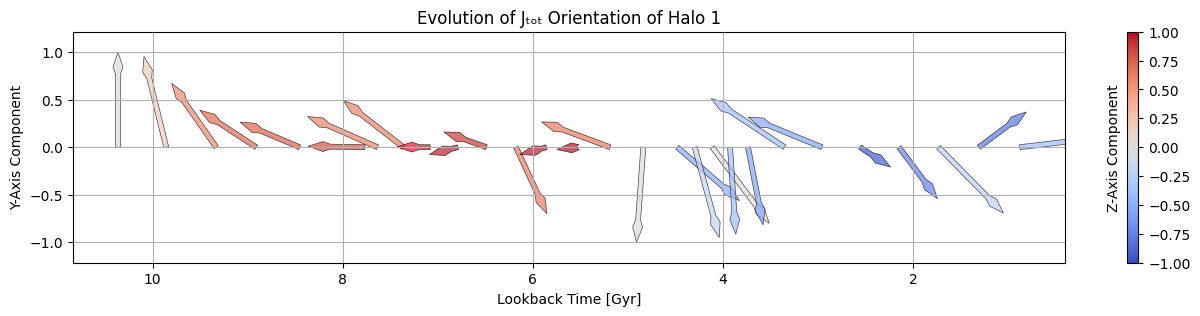

In [10]:
scale           = 1
proj_vec        = spinTOT[1,:]
x_vec           = spinTOT[2,:]
plotheight      = 3
plotwidth       = 16

#pltcolors = pyimport("matplotlib.colors")
pltcm           = pyimport("matplotlib.cm")
pltcolors       = pyimport("matplotlib.colors")
colormap        = pltcm.get_cmap(name="coolwarm")




#fig = figure(figsize=(16,9))
#ax1 = fig.add_subplot()

y = zeros(length(lookbacktime))
x = zeros(length(lookbacktime))

fig, ax = subplots()

ax.set_title("Evolution of Jₜₒₜ Orientation of Halo $(haloID)")

#ax.set_ylim(-(maximum(lookbacktime)-minimum(lookbacktime))/2*(plotheight/plotwidth), (maximum(lookbacktime)-minimum(lookbacktime))/2*(plotheight/plotwidth))
ax.set_ylim(-1, 1)

ax.quiver(lookbacktime, y, 
        x_vec, spinTOT[3,:],
        color=colormap(proj_vec.*0.5.+0.5), scale_units="y", scale=scale, alpha=0.7, width=0.005, headwidth=2, headlength=3, edgecolor="black", lw=0.5)

ax.set_xlabel("Lookback Time [Gyr]")
ax.invert_xaxis()
ax.set_ylabel("Y-Axis Component")
ax.grid()
clb = fig.colorbar(pltcm.ScalarMappable(norm=pltcolors.Normalize(vmin=-1, vmax=1), cmap="coolwarm"))
clb.ax.set_ylabel("Z-Axis Component")
#clb.ax.yaxis.tick_left()
clb.ax.yaxis.set_label_position("left")
fig.gca().set_aspect("equal", adjustable="datalim")
fig.set_size_inches(plotwidth, plotheight)

fig.savefig(joinpath(@__DIR__, "plots/halo_$(haloID)_vectors.png"), bbox_inches="tight", pad_inches=.1)

scale           = 1
proj_vec        = lookbacktime./maximum(lookbacktime)
x_vec           = spinTOT[2,:]
plotheight      = 3
plotwidth       = 16

#pltcolors = pyimport("matplotlib.colors")
pltcm           = pyimport("matplotlib.cm")
pltcolors       = pyimport("matplotlib.colors")
colormap        = pltcm.get_cmap(name="coolwarm")


#fig = figure(figsize=(16,9))
#ax1 = fig.add_subplot()

y = zeros(length(lookbacktime))
x = zeros(length(lookbacktime))
unit_length = ones(length(lookbacktime))

fig = figure()
ax = fig.add_subplot()#polar=true)

ax.set_title("Evolution of Jₜₒₜ Orientation of Halo $(haloID)")

#ax.set_ylim(-(maximum(lookbacktime)-minimum(lookbacktime))/2*(plotheight/plotwidth), (maximum(lookbacktime)-minimum(lookbacktime))/2*(plotheight/plotwidth))
#ax.set_rlim(0, 2)

#ax.quiver(x, y, 
        #(π/180).*spherical_spinTOT[3,:], unit_length.*0.5, 
        #color=colormap(proj_vec), scale_units="y", scale=scale, alpha=0.7, width=0.02, headwidth=2, headlength=3, edgecolor="black", lw=0.5)
#ax.quiver(x, y, 
        #(π/180).*unit_length, unit_length, 
        #color=colormap(proj_vec), scale_units="y", scale=scale, alpha=0.7, width=0.005, headwidth=2, headlength=3, edgecolor="black", lw=0.5)

ax.plot(spherical_spinTOT[3,:], spherical_spinTOT[2,:], 
        "r*", color=colormap(proj_vec))

#ax.set_xlabel("Lookback Time [Gyr]")
#ax.invert_xaxis()
#ax.set_ylabel("Y-Axis Component")
#ax.grid()
clb = fig.colorbar(pltcm.ScalarMappable(norm=pltcolors.Normalize(vmin=-1, vmax=1), cmap="coolwarm"))
clb.ax.set_ylabel("Z-Axis Component")
#clb.ax.yaxis.tick_left()
clb.ax.yaxis.set_label_position("left")
#fig.gca().set_aspect("equal", adjustable="datalim")
fig.set_size_inches(plotwidth, plotheight)

#fig.savefig(joinpath(@__DIR__, "plots/halo_$(haloID)_vectors.png"), bbox_inches="tight", pad_inches=.1)

println(maximum(spherical_spinTOT[3,:]) - minimum(spherical_spinTOT[3,:]))
@show spherical_spinTOT[3,:]

In [11]:
full_lookbacktime   = Array{Float64}(undef, 0)
full_M_felix        = Array{Float64}(undef, 3, 0)

for i in 1:length(halo_story["SNAP"])
    head                = read_header("$box/groups_$(@sprintf("%03i", halo_story["SNAP"][i]))/sub_$(@sprintf("%03i", halo_story["SNAP"][i]))")
    full_lookbacktime   = vcat(full_lookbacktime, ustrip(lookback_time(cosmology(h=head.h0, OmegaM=head.omega_0), head.z)))
    full_M_felix        = hcat(full_M_felix, [convert_units_physical_mass(halo_story["M_DM"][i], head), convert_units_physical_mass(halo_story["M_GAS"][i], head), convert_units_physical_mass(halo_story["M_STARS"][i], head)])
    #println(size(full_lookbacktime), "   ---   ", size(full_M_felix))
end

println(size(full_lookbacktime))
println(size(full_M_felix))

(361,)
(3, 361)


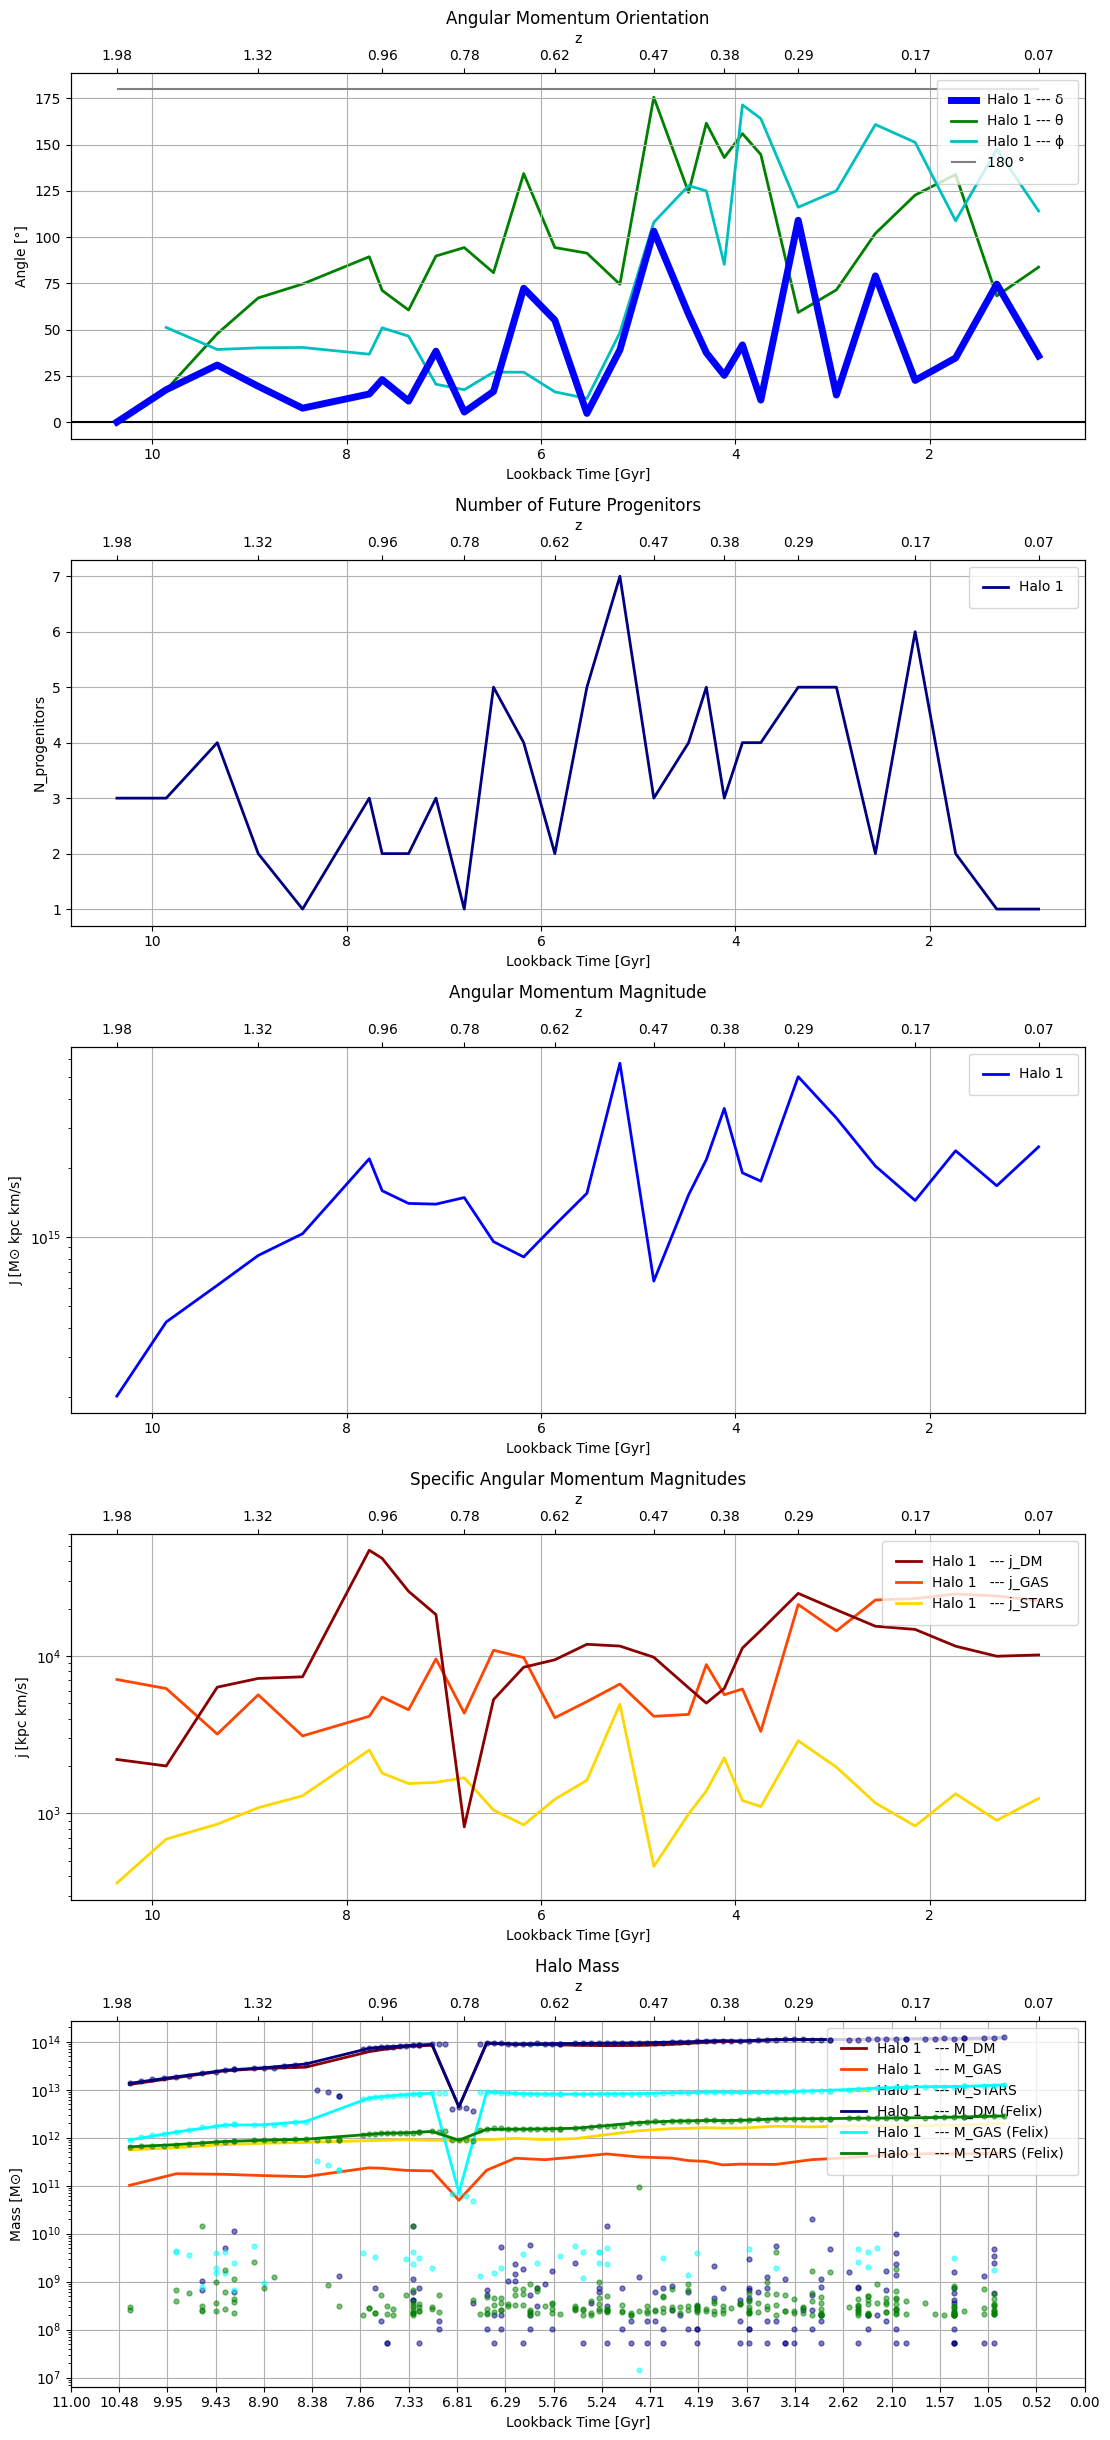

In [12]:
### Figure
N_plots = 5
z_2dec  = round.(z,digits=2) 
fig, ax = subplots(N_plots)


ax[1].plot(lookbacktime, δ_spinTOT, 
        "b-", lw=5, label="Halo $haloID --- δ", alpha=1, zorder=3)
ax[1].plot(lookbacktime, spherical_spinTOT[2,:], 
        "g-", lw=2, label="Halo $haloID --- θ", alpha=1, zorder=1)
ax[1].plot(lookbacktime[2:end], spherical_spinTOT[3,2:end], 
        "c-", lw=2, label="Halo $haloID --- ϕ", alpha=1, zorder=2)
ax[1].bar(flipsnaps, 150, color="black")
ax[1].hlines(flipangle,minimum(lookbacktime), maximum(lookbacktime), label="$flipangle °", color="grey")
ax[1].set_title("Angular Momentum Orientation")
ax[1].set_xlabel("Lookback Time [Gyr]")
ax[1].invert_xaxis()
ax[1].set_ylabel("Angle [°]")
ax[1].grid()
ax[1].axhline(color="black")
ax[1].legend(loc="upper right", frameon=true, borderpad=1, handlelength=1.8)
ax2 = ax[1].twiny()
ax2.set_xlim(ax[1].get_xlim())
ax2.set_xticks(lookbacktime[1:3:end])
ax2.set_xticklabels(z_2dec[1:3:end])
ax2.set_xlabel("z")
#ax[1].invert_xaxis()


ax[2].plot(lookbacktime, progenitors, 
        "-", lw=2, label="Halo $haloID", color="navy", alpha=1, zorder=2)
ax[2].set_xlabel("Lookback Time [Gyr]")
ax[2].set_title("Number of Future Progenitors")
ax[2].invert_xaxis()
ax[2].set_ylabel("N_progenitors")
#ax[2].set_yscale("log")
ax[2].grid()
ax[2].legend(loc="upper right", frameon=true, borderpad=1, handlelength=1.8)
ax2 = ax[2].twiny()
ax2.set_xlim(ax[1].get_xlim())
ax2.set_xticks(lookbacktime[1:3:end])
ax2.set_xticklabels(z_2dec[1:3:end])
ax2.set_xlabel("z")

#ax[2].plot(lookbacktime, abs_diff_spinTOT, 
        #"c-", lw=2, label="Halo_$haloID diffvec", alpha=1, zorder=1)
ax[3].plot(lookbacktime, spherical_spinTOT[1,:], 
        "b-", lw=2, label="Halo $haloID", alpha=1, zorder=2)
ax[3].set_title("Angular Momentum Magnitude")
ax[3].set_xlabel("Lookback Time [Gyr]")
ax[3].invert_xaxis()
ax[3].set_yscale("log")
ax[3].set_ylabel("J [M⊙ kpc km/s]")
ax[3].grid()
ax[3].legend(loc="upper right", frameon=true, borderpad=1, handlelength=1.8)
ax2 = ax[3].twiny()
ax2.set_xlim(ax[1].get_xlim())
ax2.set_xticks(lookbacktime[1:3:end])
ax2.set_xticklabels(z_2dec[1:3:end])
ax2.set_xlabel("z")

ax[4].plot(lookbacktime, j_dm, 
        "-", lw=2, label="Halo $haloID   --- j_DM", color="darkred", alpha=1, zorder=4)
ax[4].plot(lookbacktime, j_gas, 
        "-", lw=2, label="Halo $haloID   --- j_GAS", color="orangered", alpha=1, zorder=3)
ax[4].plot(lookbacktime, j_stars, 
        "-", lw=2, label="Halo $haloID   --- j_STARS", color="gold", alpha=1, zorder=2)
ax[4].set_title("Specific Angular Momentum Magnitudes")
ax[4].set_xlabel("Lookback Time [Gyr]")
ax[4].invert_xaxis()
ax[4].set_yscale("log")
ax[4].set_ylabel("j [kpc km/s]")
ax[4].grid()
ax[4].legend(loc="upper right", frameon=true, borderpad=1, handlelength=1.8)
ax2 = ax[4].twiny()
ax2.set_xlim(ax[1].get_xlim())
ax2.set_xticks(lookbacktime[1:3:end])
ax2.set_xticklabels(z_2dec[1:3:end])
ax2.set_xlabel("z")

#ax[4].plot(lookbacktime, M_tot, 
        #"b-", lw=2, label="M_tot", alpha=1, zorder=2)
ax[5].plot(lookbacktime, M_comp[1,:], 
        "-", lw=2, label="Halo $haloID   --- M_DM", color="darkred", alpha=1, zorder=2)
ax[5].plot(lookbacktime, M_comp[2,:], 
        "-", lw=2, label="Halo $haloID   --- M_GAS", color="orangered", alpha=1, zorder=3)
ax[5].plot(lookbacktime, M_comp[3,:], 
        "-", lw=2, label="Halo $haloID   --- M_STARS", color="gold", alpha=1, zorder=4)
ax[5].plot(lookbacktime, M_felix[1,:], 
        "-", lw=2, label="Halo $haloID   --- M_DM (Felix)", color="navy", alpha=1, zorder=5)
ax[5].plot(lookbacktime, M_felix[2,:], 
        "-", lw=2, label="Halo $haloID   --- M_GAS (Felix)", color="cyan", alpha=1, zorder=6)
ax[5].plot(lookbacktime, M_felix[3,:], 
        "-", lw=2, label="Halo $haloID   --- M_STARS (Felix)", color="green", alpha=1, zorder=7)
ax[5].plot(full_lookbacktime, full_M_felix[1,:], 
        ".", ms=7, color="navy", alpha=0.5, zorder=8)
ax[5].plot(full_lookbacktime, full_M_felix[2,:], 
        ".", ms=7, color="cyan", alpha=0.5, zorder=9)
ax[5].plot(full_lookbacktime, full_M_felix[3,:], 
        ".", ms=7, color="green", alpha=0.5, zorder=10)
ax[5].set_xlabel("Lookback Time [Gyr]")
ax[5].set_xticks(LinRange(11,0,22))
ax[5].set_title("Halo Mass")
ax[5].invert_xaxis()
ax[5].set_ylabel("Mass [M⊙]")
ax[5].set_yscale("log")
ax[5].grid()
ax[5].legend(loc="upper right", frameon=true, borderpad=1, handlelength=1.8)
ax2 = ax[5].twiny()
ax2.set_xlim(ax[1].get_xlim())
ax2.set_xticks(lookbacktime[1:3:end])
ax2.set_xticklabels(z_2dec[1:3:end])
ax2.set_xlabel("z")


scale=0.7
fig.set_size_inches(16scale, 7*N_plots*scale)
fig.tight_layout()


fig.savefig(joinpath(@__DIR__, "plots/halo_$(haloID)_graphs.png"), bbox_inches="tight", pad_inches=.1)

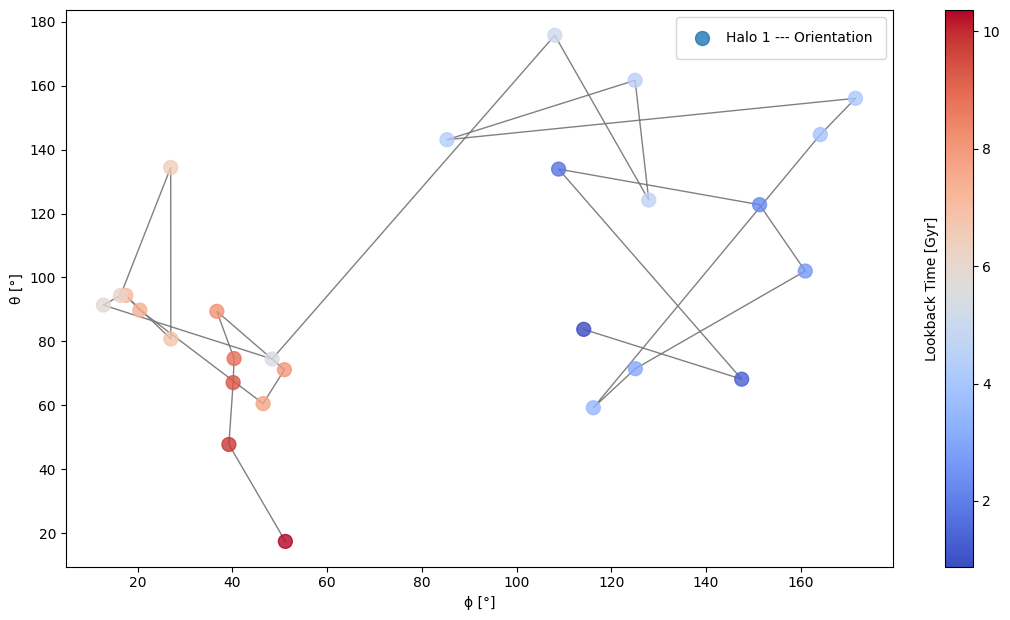

In [14]:
# Plotting Precession
proj_vec = lookbacktime / maximum(lookbacktime)

scale=0.7

pltcm           = pyimport("matplotlib.cm")
pltcolors       = pyimport("matplotlib.colors")
colormap        = pltcm.get_cmap(name="coolwarm")


fig, ax = subplots()

ax.plot(spherical_spinTOT[3,:], spherical_spinTOT[2,:], "-", lw=1, color="grey", alpha=1, zorder=2)
ax.scatter(spherical_spinTOT[3,:], spherical_spinTOT[2,:], s=100, c=proj_vec, label="Halo $haloID --- Orientation", cmap=colormap, alpha=0.8, zorder=3)

ax.set_xlabel("ϕ [°]")
#ax.set_ylim(0,180)
#ax.set_xscale("log")
ax.set_ylabel("θ [°]")
#ax.set_yscale("log")
ax.legend(loc="upper right", frameon=true, borderpad=1, handlelength=1.8)
#ax.grid()
clb = fig.colorbar(pltcm.ScalarMappable(norm=pltcolors.Normalize(vmin=minimum(lookbacktime), vmax=maximum(lookbacktime)), cmap="coolwarm"))
clb.ax.set_ylabel("Lookback Time [Gyr]")
#clb.ax.yaxis.tick_left()
clb.ax.yaxis.set_label_position("left")


fig.set_size_inches(16scale, 9scale)
fig.tight_layout()

#fig.savefig(joinpath(@__DIR__, "plots/halo_$(haloID)_vectors.png"), bbox_inches="tight", pad_inches=.1)